In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! cp "/content/gdrive/My Drive/racedata/graydata/GrayA" /content/
! cp "/content/gdrive/My Drive/racedata/graydata/GrayB" /content/

cp: -r not specified; omitting directory '/content/gdrive/My Drive/racedata/graydata/GrayA'
cp: -r not specified; omitting directory '/content/gdrive/My Drive/racedata/graydata/GrayB'


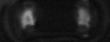

In [3]:
from PIL import Image
img = Image.open('/content/gdrive/MyDrive/racedata/graydata/GrayA/0/20190802023050_8SSB20N60164H1DG97Y02G6_R1248_1_SolderLight.png')
img

In [4]:
# load the Keras libraries.
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [5]:
img_width, img_height = 224, 224
nb_train_samples = 12000
nb_validation_samples = 200
epochs = 100
batch_size = 32
n_classes = 8

In [6]:
train_data_dir = "/content/gdrive/MyDrive/racedata/graydata/GrayA/"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    validation_split= 0.2,
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset= "training"
    )

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset= "validation"
    )

Found 9604 images belonging to 8 classes.
Found 2396 images belonging to 8 classes.


In [7]:
test_data_dir = "/content/gdrive/MyDrive/racedata/graydata/GrayB/"
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1. / 255)
new_test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 200 images belonging to 8 classes.


In [8]:
def build_model():
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     weights='imagenet', #add
                                     include_top=False,
                                     pooling='avg')
    for layer in base_model.layers:
      layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [9]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

29097984/29084464 [==============================] - 1s 0us/step


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [1]:
model_history = model.fit_generator(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

NameError: ignored

In [ ]:
#model.save('Densenetmodel.h5')
model.save('/content/gdrive/MyDrive/racedata/GrayDenseNetmodel.h5')

In [ ]:
import os
import pandas as pd
dir = "/content/gdrive/MyDrive/racedata/graydata/GrayB/"
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        #print(filename)
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':
                #print(os.path.split(dirname))
                label.append(os.path.split(dirname)[1][0])
                path.append(os.path.join(dirname,filename))
                print(os.path.join(dirname,filename))
df2 = pd.DataFrame(columns = ['path','label'])
df2['path'] = path
df2['label'] = label

In [ ]:
df2 = df2.sample(frac = 1)
df2 = df2.groupby(['label']).head(1000)
df2['label'] = df2['label'].astype('category')
df2['label'].value_counts()

In [ ]:
#以A80%訓練20%驗證 再以B測試
import numpy as np
import seaborn as sns
pred = model.predict(new_test_data)
pred=np.argmax(pred,axis=1)
pred_df=df2.copy()
labels={}
for l,v in new_test_data.class_indices.items():
    print(l)
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])
    
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')